<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

# Regressão III - Tarefa

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics           import r2_score

In [ ]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [ ]:
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [ ]:
# Imprimindo a quantidade de valores ausentes para cada variável no DataFrame
print(f'Quantidade de valores missing por variável:\n\n{df.isna().sum()}')

Quantidade de valores missing por variável:

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64


In [ ]:
# Tratei os dados dessa forma e conseguimos resolver o problema:
media = df['tempo_emprego'].dropna().mean()
df['tempo_emprego'].fillna(media, inplace = True)
df.isna().sum()


index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [ ]:
# Adicionando uma nova coluna 'renda_log' com o logaritmo natural dos valores da coluna 'renda'
df['renda_log'] = np.log(df['renda'])
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020


### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [ ]:
# Resetar o índice para transformá-lo em uma coluna
df.reset_index(inplace=True)

# Transformar a coluna "data_ref" em datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenar o DataFrame pela coluna "data_ref"
df = df.sort_values(by='data_ref')

# Selecionar os três últimos meses como base holdout
df_holdout = df[df['data_ref'] >= df['data_ref'].max() - pd.DateOffset(months=3)]

print(f'''
    Data mínima na base_teste: {df_holdout['data_ref'].min()}.
    Data máxima na base_teste: {df_holdout['data_ref'].max()}.
    ''')

df_holdout.info()


    Data mínima na base_teste: 2015-12-01 00:00:00.
    Data máxima na base_teste: 2016-03-01 00:00:00.
    
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 583335 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               200000 non-null  datetime64[ns]
 1   index                  200000 non-null  int64         
 2   sexo                   200000 non-null  object        
 3   posse_de_veiculo       200000 non-null  object        
 4   posse_de_imovel        200000 non-null  object        
 5   qtd_filhos             200000 non-null  int64         
 6   tipo_renda             200000 non-null  object        
 7   educacao               200000 non-null  object        
 8   estado_civil           200000 non-null  object        
 9   tipo_residencia        200000 non-null  object        
 10  idade                  200000 non-null  int64         

In [ ]:
df_train = df[df['data_ref'] < df['data_ref'].max() - pd.DateOffset(months=3)]
#definir como indice 'data_ref'

print(f'''
    Data mínima na base_teste: {df_train['data_ref'].min()}.
    Data máxima na base_teste: {df_train['data_ref'].max()}.
    ''')

df_train.info()


    Data mínima na base_teste: 2015-01-01 00:00:00.
    Data máxima na base_teste: 2015-11-01 00:00:00.
    
<class 'pandas.core.frame.DataFrame'>
Index: 550000 entries, 0 to 516662
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               550000 non-null  datetime64[ns]
 1   index                  550000 non-null  int64         
 2   sexo                   550000 non-null  object        
 3   posse_de_veiculo       550000 non-null  object        
 4   posse_de_imovel        550000 non-null  object        
 5   qtd_filhos             550000 non-null  int64         
 6   tipo_renda             550000 non-null  object        
 7   educacao               550000 non-null  object        
 8   estado_civil           550000 non-null  object        
 9   tipo_residencia        550000 non-null  object        
 10  idade                  550000 non-null  int64         
 11 

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [ ]:
# Ajustando um modelo de regressão linear simples utilizando a biblioteca StatsModels
modelo1 = smf.ols('renda_log ~ tempo_emprego', data=df_train).fit()
print(f'R-quadrado: {modelo1.rsquared:.2%}')
print(modelo1.summary())

R-quadrado: 42.20%
                            OLS Regression Results                            
Dep. Variable:              renda_log   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                 4.016e+05
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:51:04   Log-Likelihood:            -7.3586e+05
No. Observations:              550000   AIC:                         1.472e+06
Df Residuals:                  549998   BIC:                         1.472e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.3395   

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [ ]:
# Trouxe uma abordagem diferente, nesse caso uso os intervalos com pd.qcut no conjunto de treino, acredito que poderia estar acontecendo alguma confusão na categorização de treino e teste
quebras = pd.qcut(df_train['tempo_emprego'], 20, duplicates='drop').cat.categories

# aplico aqui a mesma discretização no conjunto de treino usando pd.cut
df_train['tempo_emprego_quantil'] = pd.cut(df_train['tempo_emprego'], bins=quebras, include_lowest=True)

# Calcular a quantidade de observações, a média do log-renda e a média do tempo de emprego para cada categoria
df_cat = (df_train
          .groupby('tempo_emprego_quantil')
          .agg({'tempo_emprego_quantil': [('Quantidade de Observações', 'count')],
                'renda_log': [('Média Log da Renda', 'mean')],
                'tempo_emprego': [('Tempo Médio Emprego', 'mean')]})
            .droplevel(level=0, axis=1))


df_cat

,Quantidade de Observações,Média Log da Renda,Tempo Médio Emprego
tempo_emprego_quantil,,,
"(0.11699999999999999, 0.816]",27490,8.422219,0.512033
"(0.816, 1.458]",27778,8.517226,1.122358
"(1.458, 2.096]",27315,8.629500,1.781155
"(2.096, 2.912]",27246,8.684367,2.508608
"(2.912, 3.636]",28056,8.817460,3.298212
"(3.636, 4.301]",27095,8.919257,3.987086
"(4.301, 4.934]",27400,8.962874,4.607338
"(4.934, 5.759]",27738,9.109146,5.363823
"(5.759, 6.622]",27474,9.201152,6.206258


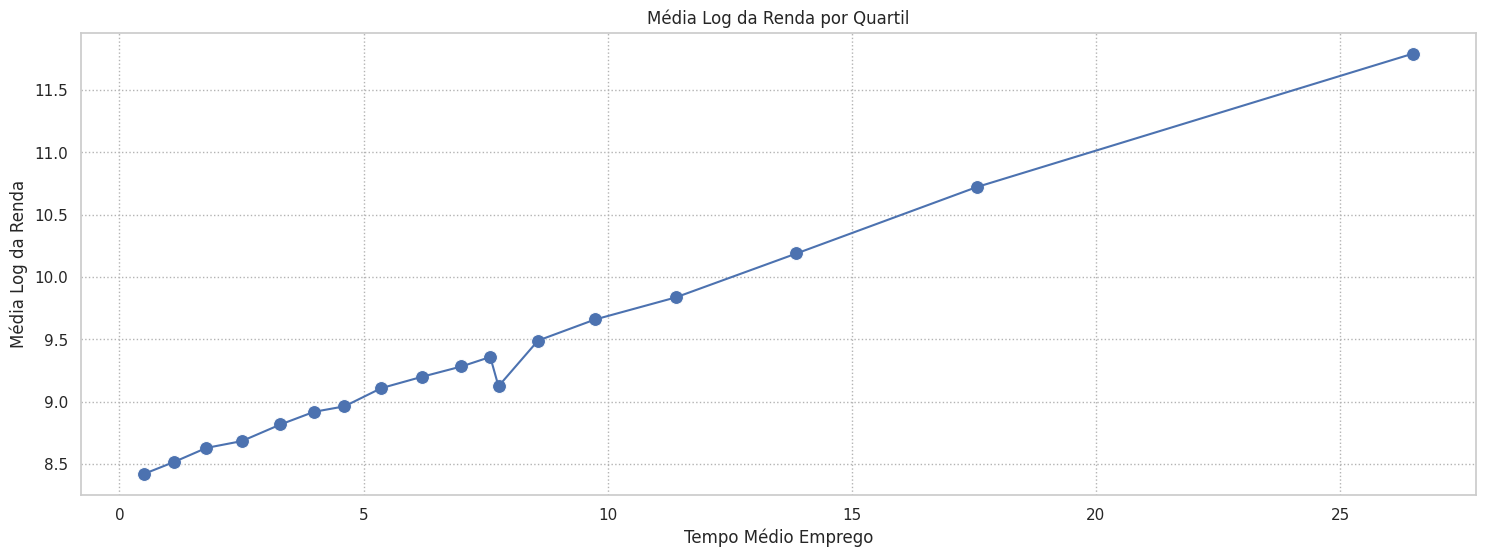

In [ ]:
# Configurando o estilo do gráfico com grade branca e estilo de linha pontilhada
sns.set(style="whitegrid", rc={"grid.color": '.7', "grid.linestyle": ':'})

# Plotar a média do log-renda por quartil
plt.figure(figsize=(18, 6))

# Plotar no gráfico
sns.scatterplot(x='Tempo Médio Emprego', y='Média Log da Renda', data=df_cat, s=100, edgecolor='w', linewidth=0.7)

# Adicionar uma linha de tendência
sns.lineplot(x='Tempo Médio Emprego', y='Média Log da Renda', data=df_cat)

# Configurar os rótulos do eixo x e y
plt.xlabel('Tempo Médio Emprego')
plt.ylabel('Média Log da Renda')

# Configurar o título do gráfico
plt.title('Média Log da Renda por Quartil')

# Exibir o gráfico
plt.show()


### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


## Categorização

In [ ]:
#usar categorização de tempo_emprego
#construindo modelo de regressão utilizando a base de treino com tempo_emprego categorizada e log_renda
modelo_cat = smf.ols('renda_log ~ tempo_emprego_quantil', data=df_train).fit()

print(f'R-quadrado ajustado: {modelo_cat.rsquared_adj:.2%}')#transformar tempo_emprego em polinômio
modelo_cat.summary()

R-quadrado ajustado: 41.81%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                 2.325e+04
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:51:12   Log-Likelihood:            -7.3769e+05
No. Observations:              550000   AIC:                         1.475e+06
Df Residuals:                  549982   BIC:                         1.476e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             8.4222      0.006   1509.203      0.000       8.411       8.433
tempo_emprego_quantil[T.Interval(0.816, 1.458, closed='right')]       0.0950      0.008     12.070      0.000       0.080       0.110
tempo_emprego_quantil[T.Interval(1.458, 2.096, closed='right')]       0.2073      0.008     26.222      0.000       0.192       0.223
tempo_emprego_quantil[T.Interval(2.096, 2.912, closed='right')]       0.2621      0.008     33.142      0.000       0.247       0.278
tempo_emprego_quantil[T.Interval(2.912, 3.636, closed='right')]       0.3952      0.008     50.335      0.000       0.380       0.411
tempo_emprego_quantil[T.Interval(3.636, 4.301, closed='right')]       0.4970      0.008     62.751      0.000       0.482       0.513
tempo_emprego_quantil[T.Interval(4.301, 4.934, closed='right')]       0.5407      0.008     68.449      0.000       0.525       0.556
tempo_emprego_quantil[T.Interval(4.934, 5.759, closed='right')]       0.6869      0.008     87.235      0.000       0.671       0.702
tempo_emprego_quantil[T.Interval(5.759, 6.622, closed='right')]       0.7789      0.008     98.683      0.000       0.763       0.794
tempo_emprego_quantil[T.Interval(6.622, 7.471, closed='right')]       0.8608      0.008    108.812      0.000       0.845       0.876
tempo_emprego_quantil[T.Interval(7.471, 7.746, closed='right')]       0.9369      0.012     80.459      0.000       0.914       0.960
tempo_emprego_quantil[T.Interval(7.746, 8.107, closed='right')]       0.7022      0.006    111.707      0.000       0.690       0.715
tempo_emprego_quantil[T.Interval(8.107, 9.09, closed='right')]        1.0684      0.008    135.059      0.000       1.053       1.084
tempo_emprego_quantil[T.Interval(9.09, 10.438, closed='right')]       1.2378      0.008    156.837      0.000       1.222       1.253
tempo_emprego_quantil[T.Interval(10.438, 12.474, closed='right')]     1.4148      0.008    179.457      0.000       1.399       1.430
tempo_emprego_quantil[T.Interval(12.474, 15.219, closed='right')]     1.7675      0.008    223.661      0.000       1.752       1.783
tempo_emprego_quantil[T.Interval(15.219, 20.274, closed='right')]     2.2997      0.008    291.815      0.000       2.284       2.315
tempo_emprego_quantil[T.Interval(20.274, 42.907, closed='right')]     3.3700      0.008    426.752      0.000       3.354       3.385
==============================================================================
Omnibus:                      625.749   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              615.329
Skew:                          -

## Transformação em X

In [ ]:
# Ajustando um novo modelo de regressão linear usando o logaritmo natural da variável 'tempo_emprego' como preditora da variável 'renda_log' no DataFrame df_train2
modelo_transf_x = smf.ols(formula='renda_log ~ I(np.log(tempo_emprego+10))', data=df_train).fit()
print(f'R-quadrado ajustado: {modelo_transf_x.rsquared_adj:.2%}')#transformar tempo_emprego em polinômio

R-quadrado ajustado: 39.60%


## Regressão Segmentada

In [ ]:
# Fiz bem semelhante a sua técnica
C1=7.5

df_train['X_1'] = (df_train.tempo_emprego<=C1)*df_train.tempo_emprego + (df_train.tempo_emprego>C1)*C1
df_train['X_2'] = (df_train.tempo_emprego<=C1)*0 + (df_train.tempo_emprego>C1)*(df_train.tempo_emprego-C1)

modelo_segmentacao = smf.ols('renda_log ~ X_1 + X_2', data=df_train).fit()

print(f'R-quadrado ajustado: {modelo_segmentacao.rsquared_adj:.2%}')

R-quadrado ajustado: 42.33%


## Lowess

In [ ]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_train.renda_log, df_train.tempo_emprego, frac=2/3)

# Valores de Y suavizados
lowess_y = lowess[:, 1]

# Valores de X suavizados
lowess_x = lowess[:, 0]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_train['lowess'] = f(df_train.tempo_emprego)
df_train.head()

In [ ]:
# Ajustando um novo modelo de regressão linear (modelo7) usando a variável 'lowess' como preditora da variável 'renda_log' no DataFrame df_train2
modelo_lowess = smf.ols(formula='renda_log ~ lowess', data=df_train).fit()
print(f'R-quadrado ajustado: {modelo_lowess.rsquared_adj:.2%}')

R-quadrado ajustado: 42.51%


### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [ ]:
#CAT
df_holdout['tempo_emprego_quantil'] = pd.cut(df_holdout['tempo_emprego'], bins=quebras, include_lowest=True)

df_holdout['pred2'] = modelo_cat.predict(df_holdout)
r = df_holdout[['pred2', 'renda_log']].corr().iloc[0, 1]
r2 = r**2

print(f'R-quadrado ajustado modelo_cat: {modelo_cat.rsquared_adj:.2%}')
print(f'R-quadrado ajustado com dados de teste: {r2:.2%}')

R-quadrado ajustado modelo_cat: 41.81%
R-quadrado ajustado com dados de teste: 49.73%


In [ ]:
df_holdout['pred4_transf_x'] = modelo_transf_x.predict(df_holdout)
r = df_holdout[['pred4_transf_x', 'renda_log']].corr().iloc[0,1]
r2 = r**2

print(f'R-quadrado ajustado modelo_transf_x: {modelo_transf_x.rsquared_adj:.2%}')
print(f'R-quadrado ajustado aos dados de teste: {r2:.2%}')

R-quadrado ajustado modelo_transf_x: 39.60%
R-quadrado ajustado aos dados de teste: 47.02%


In [ ]:
#SEGMENTADA
C1 = 7.5
df_holdout['X_1'] = (df_holdout.tempo_emprego<=C1)*df_holdout.tempo_emprego + (df_holdout.tempo_emprego>C1)*C1
df_holdout['X_2'] = (df_holdout.tempo_emprego<=C1)*0 + (df_holdout.tempo_emprego>C1)*(df_holdout.tempo_emprego-C1)

df_holdout['pred3'] = modelo_segmentacao.predict(df_holdout)
r = df_holdout[['pred3', 'renda_log']].corr().iloc[0,1]
r2 = r**2

print(f'R-quadrado ajustado modelo_segmentacao: {modelo_segmentacao.rsquared_adj:.2%}')
print(f'R-quadrado ajustado aos dados de teste: {r2:.2%}')

R-quadrado ajustado modelo_segmentacao: 42.33%
R-quadrado ajustado aos dados de teste: 50.37%


In [ ]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_holdout.renda_log, df_holdout.tempo_emprego, frac=2/3)

# Valores de Y suavizados
lowess_y = lowess[:, 1]

# Valores de X suavizados
lowess_x = lowess[:, 0]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_holdout['lowess'] = f(df_holdout.tempo_emprego)

df_holdout['pred5'] = modelo_lowess.predict(df_holdout)
r = df_holdout[['pred5', 'renda_log']].corr().iloc[0,1]
r2 = r**2

print(f'R-quadrado ajustado modelo_lowess: {modelo_lowess.rsquared_adj:.2%}')
print(f'R-quadrado ajustado aos dados de teste: {r2:.2%}')

R-quadrado ajustado modelo_lowess: 42.51%
R-quadrado ajustado aos dados de teste: 50.59%
